In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a href="https://colab.research.google.com/gist/sayakmisra/6133be0554ce916d8cae4cdb83d475d8/text-summarization-seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
!pip install wget
import wget
import nltk

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=2963b991a94979e66dbfb23b00b2f76dac7ac3e4950919b52d29875cfaa736ed
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
#!unzip '/content/drive/My Drive/text_summarizer_datasets/amazon-fine-food-reviews.zip'

In [4]:
# data = pd.read_csv("cyptocurrency/crypto_news_parsed_2013-2017_train.csv",nrows=100000)
# data[['Title','Text']].sample(5)

summary = pd.read_csv('drive/MyDrive/news-summary/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('drive/MyDrive/news-summary/news_summary_more.csv', encoding='iso-8859-1')


In [5]:
pre1 =  raw.iloc[:,0:2].copy()
pre1

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhattisgarh,"A CRPF jawan was on Tuesday axed to death with sharp-edged weapons by Maoists at a local village fair in Chhattisgarh's insurgency-hit Bijapur district. As per preliminary information, Maoists att..."
98397,First song from Sonakshi Sinha's 'Noor' titled 'Uff Yeh' out,"'Uff Yeh', the first song from the Sonakshi Sinha starrer upcoming drama film 'Noor' has been released. The song has been composed by Amaal Mallik with vocals by Armaan Malik and lyrics by Manoj M..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 1999 science fiction film 'The Matrix' is in development. Michael B Jordan will reportedly play the lead role in the film. Screenwriter Zak Penn is in ta..."
98399,Snoop Dogg aims gun at clown dressed as Trump in new video,A new music video shows rapper Snoop Dogg aiming a toy gun at a clown character parodying US President Donald Trump. The video also shows a TV airing a news conference with the headline 'Ronald Kl...


In [6]:
pre2 = summary.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [7]:
pre2['text']

0       Chhavi Tyagi 03 Aug 2017,Thursday http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.h...
1       Daisy Mowke 03 Aug 2017,Thursday http://www.hindustantimes.com/bollywood/malaika-arora-khan-was-trolled-for-divorcing-a-rich-man-her-reply-is-dignity-itself/story-oIPZNI9deImCmabLMMwR2H.html?utm_s...
2       Arshiya Chopra 03 Aug 2017,Thursday http://www.hindustantimes.com/patna/bihar-igims-form-loses-virginity-after-row-opts-for-unmarried-instead/story-8XmHIg39otGBoZAYEBQxMK.html?utm_source=inshorts&...
3       Sumedha Sehra 03 Aug 2017,Thursday http://indiatoday.intoday.in/story/abu-dujana-last-phone-call-lashkar-e-taiba-jammu-and-kashmir/1/1017550.html?utm_source=inshorts&utm_medium=referral&utm_campai...
4       Aarushi Maheshwari 03 Aug 2017,Thursday http://indiatoday.intoday.in/story/sex-trafficking-mumbai-rescue-me-maharashtra-international-labour-organization-forced

In [8]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [9]:
pre.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",upGrad learner switches to career in ML & Al with 90% salary hike
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",Delhi techie wins free food from Swiggy for one year on CRED


In [10]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.49.0-cp37-none-any.whl size=19468 sha256=aa5259631cdfa345ba3dbff919d53ba9fd2e093fcbfec9f5324330a806707fa4
  Stored in directory: /root/.cache/pip/wheels/6f/9d/c5/26693a5092d9313daeae94db04818fc0a2b7a48ea381989f34
Successfully built keras-self-attention


In [11]:
pre['text'][:10]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...
1    Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...
2    New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3    With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...
4    Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement w

In [12]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(row):
    row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
    row=re.sub("(\\r)", ' ', str(row)).lower() 
    row=re.sub("(\\n)", ' ', str(row)).lower()

    row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
    row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
    row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
    row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
    row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively

    row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!

    row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
    row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
    row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
    row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM


    row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
    row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
    row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)

    row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

    #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
        repl_url = url.group(3)
        row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
    except:
        pass #there might be emails with no url in them



    row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces

    #Should always be last
    row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
    
    return row
        
#     tokens = [w for w in row.split() if not w in stop_words]
#     long_words=[]
#     for i in tokens:
#         if len(i)>=3:                  #removing short word
#             long_words.append(i)   
#     return (" ".join(long_words)).strip()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
cleaned_text = []

for t in pre['text']:
    res= text_cleaner(t)
    cleaned_text.append(res)

In [15]:
cleaned_text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [16]:
cleaned_summary = []

for t in pre['summary']:
    res= '_START_ '+ text_cleaner(t) + ' _END_'
    cleaned_summary.append(res)

In [17]:
cleaned_summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [18]:
pre['cleaned_text'] = pd.Series(cleaned_text)
pre['cleaned_summary'] = pd.Series(cleaned_summary)

In [19]:
text_count = []
summary_count = []
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [20]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

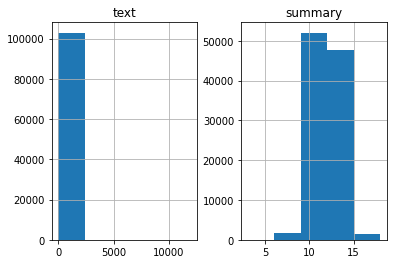

In [21]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [22]:
fcnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9978234465335472


In [23]:
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.9578389933440218


In [24]:
for i in range(5):
    print("Review:",pre['cleaned_text'][i])
    print("Summary:",pre['cleaned_summary'][i])
    print("\n")

Review: saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.
Summary: _START_ upgrad learner switches to career in ml al with 90% salary hike _END_


Review: kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult.fit and more.
Summary: _START_ delhi techie wins free food from swiggy for one year on cred _END_


Review: new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the

In [25]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [26]:
#Select the Summaries and Text between max len defined above

pre_cleaned_text =np.array(pre['cleaned_text'])
pre_cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(pre_cleaned_text)):
    if(len(pre_cleaned_summary[i].split())<=max_summary_len and len(pre_cleaned_text[i].split())<=max_text_len):
        short_text.append(pre_cleaned_text[i])
        short_summary.append(pre_cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [27]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,_START_ upgrad learner switches to career in ml al with 90% salary hike _END_
1,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,_START_ delhi techie wins free food from swiggy for one year on cred _END_


In [28]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [29]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgra...,sostok _START_ upgrad learner switches to career in ml al with 90% salary hike _END_ eostok
1,kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users ge...,sostok _START_ delhi techie wins free food from swiggy for one year on cred _END_ eostok


In [30]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [31]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [32]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.91270391131826
Total Coverage of rare words: 1.3404923996005096


In [33]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33412


In [34]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [35]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.34503603813067
Total Coverage of rare words: 3.566630093901333


In [36]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11581


In [37]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [38]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [39]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 33412
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     6682400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 4)

In [42]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs= 50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
692/692 [==============================] - 820s 1s/step - loss: 5.4405 - val_loss: 4.7655
Epoch 2/50
692/692 [==============================] - 805s 1s/step - loss: 4.7237 - val_loss: 4.4516
Epoch 3/50
692/692 [==============================] - 805s 1s/step - loss: 4.3907 - val_loss: 4.1819
Epoch 4/50
692/692 [==============================] - 803s 1s/step - loss: 4.1226 - val_loss: 4.0078
Epoch 5/50
692/692 [==============================] - 805s 1s/step - loss: 3.9425 - val_loss: 3.8773
Epoch 6/50
692/692 [==============================] - 804s 1s/step - loss: 3.8021 - val_loss: 3.7830
Epoch 7/50
692/692 [==============================] - 805s 1s/step - loss: 3.6879 - val_loss: 3.7058
Epoch 8/50
692/692 [==============================] - 803s 1s/step - loss: 3.5954 - val_loss: 3.6369
Epoch 9/50
692/692 [==============================] - 805s 1s/step - loss: 3.5069 - val_loss: 3.5803
Epoch 10/50
692/692 [==============================] - 804s 1s/step - loss: 3.4356 - val_lo

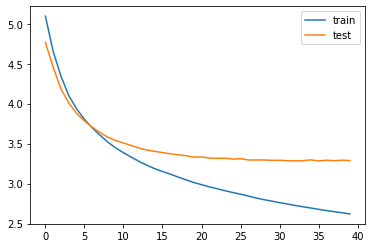

In [50]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [51]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [52]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [53]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [54]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [55]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: pope francis on tuesday called for respect for each ethnic group in speech delivered in myanmar avoiding reference to the rohingya minority community as the nation works to restore peace the healing of wounds must be priority he said the pope myanmar visit comes amid the country military crackdown resulting in the rohingya refugee crisis 
Original summary: start pope avoids mention of rohingyas in key myanmar speech end 
Predicted summary:  start pope urges people to return to myanmar in myanmar end


Review: students of government school in uttar pradesh sambhal were seen washing dishes at in school premises on being approached basic shiksha adhikari virendra pratap singh said yes have also received this complaint from elsewhere we are inquiring and action will be taken against those found guilty 
Original summary: start students seen washing dishes at govt school in up end 
Predicted summary:  start students protest at up school in up school end


Review: apple india profit s